# Stock Price Prediction with LSTM
# Overview
This Python script uses Long Short-Term Memory (LSTM) neural network model to predict stock prices. The process involves data retrieval, preprocessing, model training, performance evaluation, and visualization of the predictions.

Steps
Data Retrieval: Historical stock price data for the given stock name, 'AAPL', is retrieved using the yfinance library.

Data Preprocessing: Additional features such as 5-day and 20-day moving averages are calculated and the data is split into training and test sets.

LSTM Model Training: LSTM model is defined with two LSTM layers and compiled with optimizer and loss function. The model is then trained using the training data for 50 epochs.

Performance Evaluation: Performance metrics such as Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, R-squared, and accuracy are calculated for both training and test data.

Visualization: The model's predictions are plotted against the actual stock prices to provide a visual representation of the predictions.

Libraries Used:
1. pandas
2. numpy
3. yfinance
4. matplotlib
5. scikit-learn
6. TensorFlow

# Accuracy results

1. For Apple : 93.717%
2. For Microsoft : 92.23%

[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
54/54 [==============================] - 9s 69ms/step - loss: 0.0090 - val_loss: 0.0022
Epoch 2/50
54/54 [==============================] - 3s 52ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 3/50
54/54 [==============================] - 4s 75ms/step - loss: 9.8192e-04 - val_loss: 0.0031
Epoch 4/50
54/54 [==============================] - 3s 58ms/step - loss: 8.9312e-04 - val_loss: 0.0031
Epoch 5/50
54/54 [==============================] - 3s 53ms/step - loss: 8.7007e-04 - val_loss: 0.0017
Epoch 6/50
54/54 [==============================] - 3s 56ms/step - loss: 7.8233e-04 - val_loss: 0.0017
Epoch 7/50
54/54 [==============================] - 5s 85ms/step - loss: 6.5754e-04 - val_loss: 0.0022
Epoch 8/50
54/54 [==============================] - 4s 65ms/step - loss: 7.5013e-04 - val_loss: 0.0019
Epoch 9/50
54/54 [==============================] - 3s 60ms/step - loss: 7.9457e-04 - val_loss: 0.0026
Epoch 10/50
54/54 [==============================] - 3s 53ms/step - loss: 6.7660e

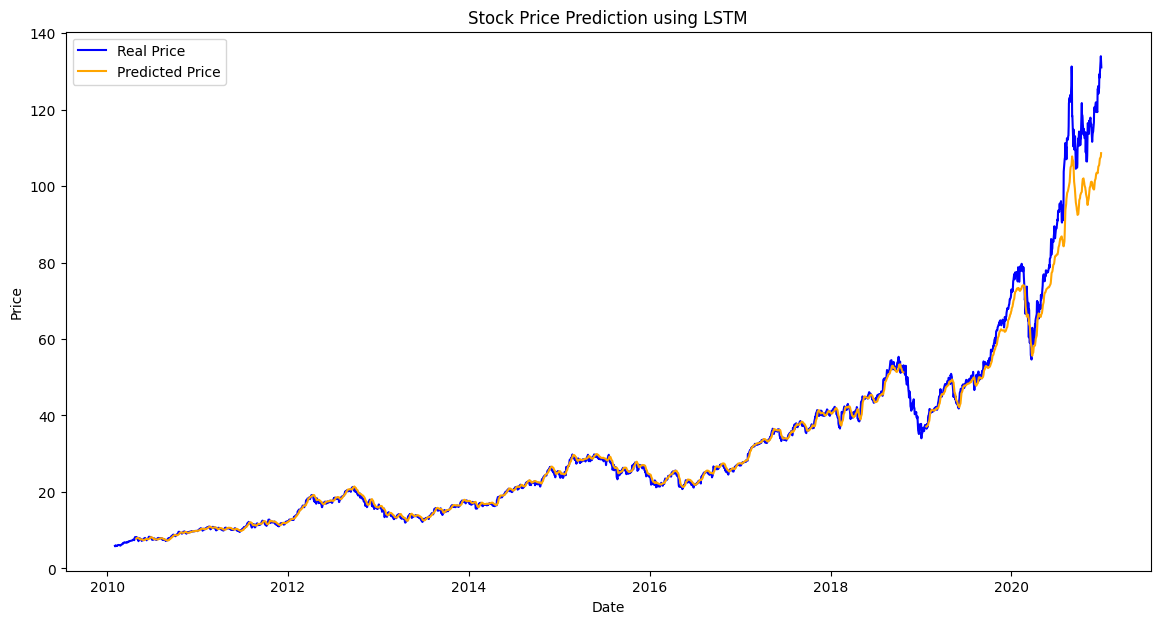

In [ ]:
#model 4
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Main Variables
stock_name = 'AAPL'
start_date = '2010-01-01'
end_date = '2020-10-31'
pred_end_date = '2020-12-31'

# Download and Prepare Data
prices = yf.download(tickers=stock_name, start=start_date, end=pred_end_date)['Adj Close']
prices = prices.reset_index()
prices['Date'] = pd.to_datetime(prices['Date'])

# Calculate additional features (moving averages)
prices['MA_5'] = prices['Adj Close'].rolling(window=5).mean()
prices['MA_20'] = prices['Adj Close'].rolling(window=20).mean()
prices.dropna(inplace=True)

# Train-test split
train_set, test_set = train_test_split(prices, test_size=0.2, shuffle=False)

# Data Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_set[['Adj Close', 'MA_5', 'MA_20']])

# Prepare the training data
sequence_length = 60  # Can try different values for optimal performance
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:i+seq_length, :]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train, Y_train = create_sequences(scaled_data, sequence_length)

# Prepare the test data
scaled_test_data = scaler.transform(test_set[['Adj Close', 'MA_5', 'MA_20']])
X_test, Y_test = create_sequences(scaled_test_data, sequence_length)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Invert scaling
pred_train = scaler.inverse_transform(np.hstack((pred_train, np.zeros((pred_train.shape[0], 2)))))
Y_train = scaler.inverse_transform(np.hstack((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], 2)))))
pred_test = scaler.inverse_transform(np.hstack((pred_test, np.zeros((pred_test.shape[0], 2)))))
Y_test = scaler.inverse_transform(np.hstack((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 2)))))

# Calculate Metrics
mse_train = mean_squared_error(Y_train[:,0], pred_train[:,0])
mse_test = mean_squared_error(Y_test[:,0], pred_test[:,0])
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
mae_train = mean_absolute_error(Y_train[:,0], pred_train[:,0])
mae_test = mean_absolute_error(Y_test[:,0], pred_test[:,0])
r2_train = r2_score(Y_train[:,0], pred_train[:,0])
r2_test = r2_score(Y_test[:,0], pred_test[:,0])
mape_train = np.mean(np.abs((Y_train[:,0] - pred_train[:,0]) / Y_train[:,0])) * 100
mape_test = np.mean(np.abs((Y_test[:,0] - pred_test[:,0]) / Y_test[:,0])) * 100
accuracy_train = 100 - mape_train
accuracy_test = 100 - mape_test

print(f'Train MSE: {mse_train}, Test MSE: {mse_test}')
print(f'Train RMSE: {rmse_train}, Test RMSE: {rmse_test}')
print(f'Train MAE: {mae_train}, Test MAE: {mae_test}')
print(f'Train R2: {r2_train}, Test R2: {r2_test}')
print(f'Train Accuracy: {accuracy_train}%, Test Accuracy: {accuracy_test}%')

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(prices['Date'], prices['Adj Close'], color='blue', label="Actual Price")
train_dates = prices['Date'].iloc[sequence_length:len(train_set)-1]
test_dates = prices['Date'].iloc[len(train_set)+sequence_length:-1]
plt.plot(train_dates, pred_train[:,0], color='orange', label="Train Prediction")
plt.plot(test_dates, pred_test[:,0], color='orange', label="Test Prediction")
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Real Price', 'Predicted Price'])
plt.show()

# This Simulation is For Microsoft Stock.

[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
54/54 [==============================] - 8s 68ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 2/50
54/54 [==============================] - 3s 52ms/step - loss: 6.8222e-04 - val_loss: 0.0050
Epoch 3/50
54/54 [==============================] - 3s 61ms/step - loss: 6.9507e-04 - val_loss: 0.0026
Epoch 4/50
54/54 [==============================] - 4s 67ms/step - loss: 5.9955e-04 - val_loss: 0.0013
Epoch 5/50
54/54 [==============================] - 3s 52ms/step - loss: 6.0774e-04 - val_loss: 0.0037
Epoch 6/50
54/54 [==============================] - 3s 53ms/step - loss: 4.6610e-04 - val_loss: 9.3408e-04
Epoch 7/50
54/54 [==============================] - 3s 54ms/step - loss: 4.9132e-04 - val_loss: 0.0026
Epoch 8/50
54/54 [==============================] - 4s 76ms/step - loss: 4.0088e-04 - val_loss: 5.8787e-04
Epoch 9/50
54/54 [==============================] - 3s 52ms/step - loss: 4.2077e-04 - val_loss: 0.0021
Epoch 10/50
54/54 [==============================] - 3s 53ms/step - l

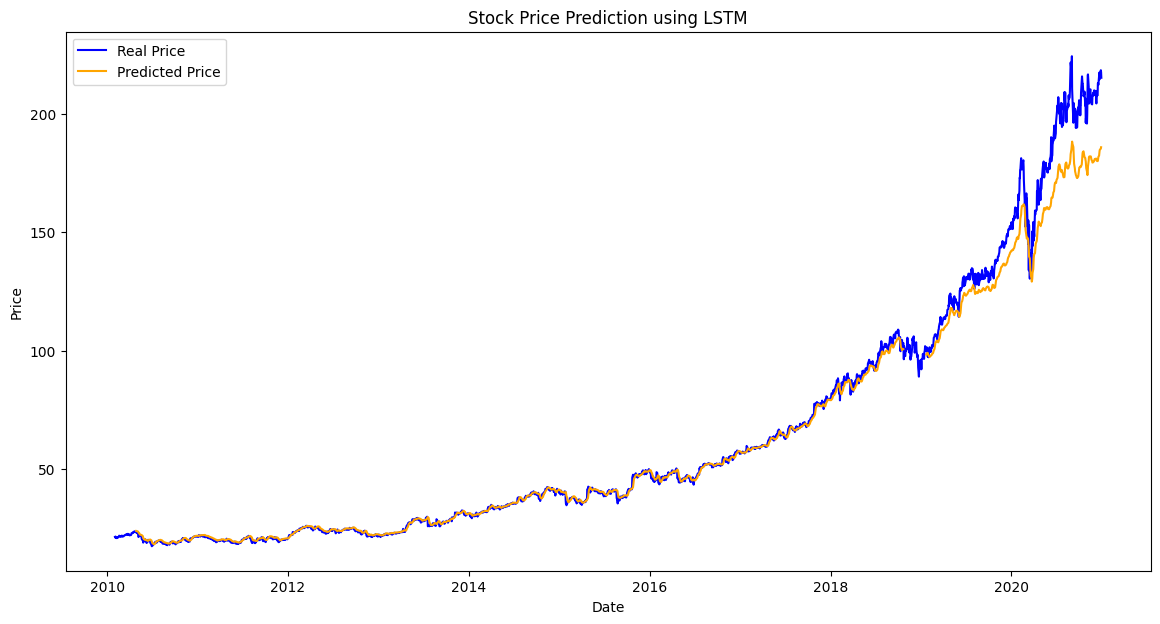

In [ ]:
#model 4
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Main Variables
stock_name = 'MSFT'
start_date = '2010-01-01'
end_date = '2020-10-31'
pred_end_date = '2020-12-31'

# Download and Prepare Data
prices = yf.download(tickers=stock_name, start=start_date, end=pred_end_date)['Adj Close']
prices = prices.reset_index()
prices['Date'] = pd.to_datetime(prices['Date'])

# Calculate additional features (moving averages)
prices['MA_5'] = prices['Adj Close'].rolling(window=5).mean()
prices['MA_20'] = prices['Adj Close'].rolling(window=20).mean()
prices.dropna(inplace=True)

# Train-test split
train_set, test_set = train_test_split(prices, test_size=0.2, shuffle=False)

# Data Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_set[['Adj Close', 'MA_5', 'MA_20']])

# Prepare the training data
sequence_length = 60  # Can try different values for optimal performance
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:i+seq_length, :]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train, Y_train = create_sequences(scaled_data, sequence_length)

# Prepare the test data
scaled_test_data = scaler.transform(test_set[['Adj Close', 'MA_5', 'MA_20']])
X_test, Y_test = create_sequences(scaled_test_data, sequence_length)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Invert scaling
pred_train = scaler.inverse_transform(np.hstack((pred_train, np.zeros((pred_train.shape[0], 2)))))
Y_train = scaler.inverse_transform(np.hstack((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], 2)))))
pred_test = scaler.inverse_transform(np.hstack((pred_test, np.zeros((pred_test.shape[0], 2)))))
Y_test = scaler.inverse_transform(np.hstack((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 2)))))

# Calculate Metrics
mse_train = mean_squared_error(Y_train[:,0], pred_train[:,0])
mse_test = mean_squared_error(Y_test[:,0], pred_test[:,0])
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
mae_train = mean_absolute_error(Y_train[:,0], pred_train[:,0])
mae_test = mean_absolute_error(Y_test[:,0], pred_test[:,0])
r2_train = r2_score(Y_train[:,0], pred_train[:,0])
r2_test = r2_score(Y_test[:,0], pred_test[:,0])
mape_train = np.mean(np.abs((Y_train[:,0] - pred_train[:,0]) / Y_train[:,0])) * 100
mape_test = np.mean(np.abs((Y_test[:,0] - pred_test[:,0]) / Y_test[:,0])) * 100
accuracy_train = 100 - mape_train
accuracy_test = 100 - mape_test

print(f'Train MSE: {mse_train}, Test MSE: {mse_test}')
print(f'Train RMSE: {rmse_train}, Test RMSE: {rmse_test}')
print(f'Train MAE: {mae_train}, Test MAE: {mae_test}')
print(f'Train R2: {r2_train}, Test R2: {r2_test}')
print(f'Train Accuracy: {accuracy_train}%, Test Accuracy: {accuracy_test}%')

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(prices['Date'], prices['Adj Close'], color='blue', label="Actual Price")
train_dates = prices['Date'].iloc[sequence_length:len(train_set)-1]
test_dates = prices['Date'].iloc[len(train_set)+sequence_length:-1]
plt.plot(train_dates, pred_train[:,0], color='orange', label="Train Prediction")
plt.plot(test_dates, pred_test[:,0], color='orange', label="Test Prediction")
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Real Price', 'Predicted Price'])
plt.show()